In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
import matplotlib.pyplot as plt


In [14]:
# we load data from student-por file, assign targets which we want to predict: G3 and Romantic (yes/no)
# then we standardize everything so all features on same scale
df = pd.read_csv('student-por.csv', sep=';')

target_grade = df['G3'].values.astype(np.float32)
target_romantic = (df['romantic'] == 'yes').astype(np.int64)

df_features = df.drop(['G3', 'romantic'], axis=1)

categorical_cols = df_features.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col])

scaler = StandardScaler()
X = scaler.fit_transform(df_features.values).astype(np.float32)


In [15]:
# splitting data into train/val/test sets
# first split off 20% for test, then split remaining into 80/20 train/val
X_temp, X_test, y_grade_temp, y_grade_test, y_romantic_temp, y_romantic_test = train_test_split(
    X, target_grade, target_romantic, test_size=0.2, random_state=42
)
X_train, X_val, y_grade_train, y_grade_val, y_romantic_train, y_romantic_val = train_test_split(
    X_temp, y_grade_temp, y_romantic_temp, test_size=0.2, random_state=42
)

In [16]:
# custom dataset class that holds features and both targets together
class StudentDataset(Dataset):
    def __init__(self, X, y_grade, y_romantic):
        if hasattr(y_grade, 'values'):
            y_grade = y_grade.values
        if hasattr(y_romantic, 'values'):
            y_romantic = y_romantic.values
        self.X = torch.FloatTensor(X)
        self.y_grade = torch.FloatTensor(y_grade)
        self.y_romantic = torch.LongTensor(y_romantic)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_grade[idx], self.y_romantic[idx]


In [17]:
# wrapping datasets in dataloaders so we can batch em up during training
# batch size 32 is pretty standard, shuffle train but not val/test
train_dataset = StudentDataset(X_train, y_grade_train, y_romantic_train)
val_dataset = StudentDataset(X_val, y_grade_val, y_romantic_val)
test_dataset = StudentDataset(X_test, y_grade_test, y_romantic_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [18]:
#got two separate heads - one for grade prediction (regression) and one for romantic status (classification)

class MultiTaskModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Shared body
        self.body = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )

        # Grade prediction head (regression)
        self.grade_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Romantic status head (classification)
        self.romantic_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        shared = self.body(x)
        grade_out = self.grade_head(shared).squeeze()
        romantic_out = self.romantic_head(shared)
        return grade_out, romantic_out


In [19]:
# initializing model with right input size and setting up optimizer
# MSE loss for regression (grade prediction) and CrossEntropy for classification (romantic status)
model = MultiTaskModel(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn_grade = nn.MSELoss()
loss_fn_romantic = nn.CrossEntropyLoss()



In [20]:

# Training function
def train_epoch(model, loader, optimizer, alpha=0.5):
    model.train()
    total_loss, grade_loss_sum, romantic_loss_sum = 0, 0, 0

    for X_batch, y_grade_batch, y_romantic_batch in loader:
        optimizer.zero_grad()

        grade_pred, romantic_pred = model(X_batch)

        loss_grade = loss_fn_grade(grade_pred, y_grade_batch)
        loss_romantic = loss_fn_romantic(romantic_pred, y_romantic_batch)

        # loss = alpha * loss_grade + (1 - alpha) * loss_romantic
        loss = 0.1 * loss_grade + 0.9 * loss_romantic
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        grade_loss_sum += loss_grade.item()
        romantic_loss_sum += loss_romantic.item()

    n = len(loader)
    return total_loss / n, grade_loss_sum / n, romantic_loss_sum / n


In [21]:

# Validation function
def validate(model, loader):
    model.eval()
    total_loss, grade_loss_sum, romantic_loss_sum = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_grade_batch, y_romantic_batch in loader:
            grade_pred, romantic_pred = model(X_batch)

            loss_grade = loss_fn_grade(grade_pred, y_grade_batch)
            loss_romantic = loss_fn_romantic(romantic_pred, y_romantic_batch)

            loss = loss_grade + loss_romantic
            total_loss += loss.item()
            grade_loss_sum += loss_grade.item()
            romantic_loss_sum += loss_romantic.item()

    n = len(loader)
    return total_loss / n, grade_loss_sum / n, romantic_loss_sum / n


In [22]:
# main training loop running 100 epochs
# each epoch we train on train set then validate on val set
# storing all losses in history dict so we can plot tem later

epochs = 100
history = {'train_total': [], 'train_grade': [], 'train_romantic': [],
           'val_total': [], 'val_grade': [], 'val_romantic': []}

for epoch in range(epochs):
    train_loss, train_grade, train_romantic = train_epoch(model, train_loader, optimizer)
    val_loss, val_grade, val_romantic = validate(model, val_loader)

    history['train_total'].append(train_loss)
    history['train_grade'].append(train_grade)
    history['train_romantic'].append(train_romantic)
    history['val_total'].append(val_loss)
    history['val_grade'].append(val_grade)
    history['val_romantic'].append(val_romantic)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Evaluation on test set
model.eval()
all_grade_preds, all_romantic_preds = [], []
all_grade_true, all_romantic_true = [], []

with torch.no_grad():
    for X_batch, y_grade_batch, y_romantic_batch in test_loader:
        grade_pred, romantic_pred = model(X_batch)
        all_grade_preds.append(grade_pred.numpy())
        all_romantic_preds.append(romantic_pred.argmax(dim=1).numpy())
        all_grade_true.append(y_grade_batch.numpy())
        all_romantic_true.append(y_romantic_batch.numpy())

all_grade_preds = np.concatenate(all_grade_preds)
all_romantic_preds = np.concatenate(all_romantic_preds)
all_grade_true = np.concatenate(all_grade_true)
all_romantic_true = np.concatenate(all_romantic_true)

# Metrics
mae = mean_absolute_error(all_grade_true, all_grade_preds)
accuracy = accuracy_score(all_romantic_true, all_romantic_preds)
f1 = f1_score(all_romantic_true, all_romantic_preds)


Epoch 10/100 - Train Loss: 2.3408, Val Loss: 13.8703
Epoch 20/100 - Train Loss: 1.0735, Val Loss: 3.2167
Epoch 30/100 - Train Loss: 1.0680, Val Loss: 2.3927
Epoch 40/100 - Train Loss: 0.8722, Val Loss: 2.1265
Epoch 50/100 - Train Loss: 0.8157, Val Loss: 2.3471
Epoch 60/100 - Train Loss: 0.7053, Val Loss: 2.2660
Epoch 70/100 - Train Loss: 0.5884, Val Loss: 2.0981
Epoch 80/100 - Train Loss: 0.6606, Val Loss: 2.4086
Epoch 90/100 - Train Loss: 0.5313, Val Loss: 2.6174
Epoch 100/100 - Train Loss: 0.4766, Val Loss: 2.7748


In [23]:
print(f"Grade Prediction MAE: {mae:.4f}")
print(f"Romantic Status Accuracy: {accuracy:.4f}")
print(f"Romantic Status F1-Score: {f1:.4f}")

Grade Prediction MAE: 1.0063
Romantic Status Accuracy: 0.5538
Romantic Status F1-Score: 0.4082


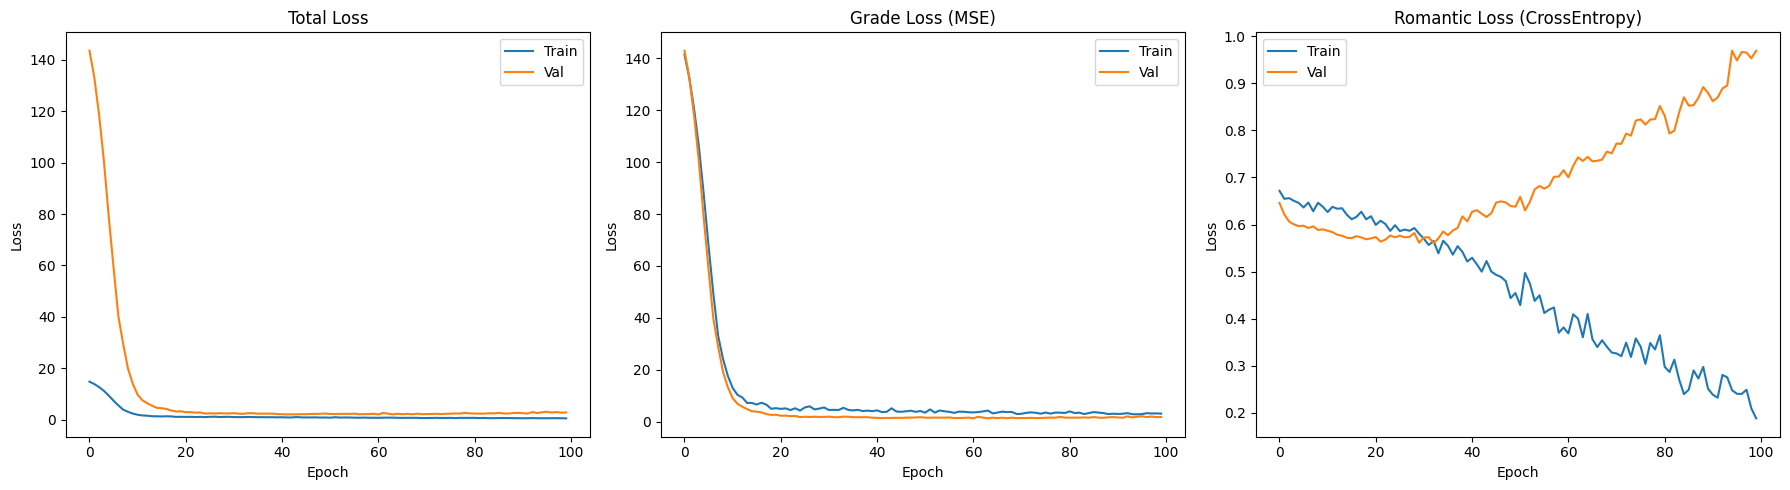

In [24]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_total'], label='Train')
axes[0].plot(history['val_total'], label='Val')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history['train_grade'], label='Train')
axes[1].plot(history['val_grade'], label='Val')
axes[1].set_title('Grade Loss (MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(history['train_romantic'], label='Train')
axes[2].plot(history['val_romantic'], label='Val')
axes[2].set_title('Romantic Loss (CrossEntropy)')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Save model
torch.save(model.state_dict(), 'multitask_model.pth')